<font color=green>**This is a draft version of the notebook, I will continue to add plots and text over time.**</font>

# Data Visualisation

## Introduction

### Why Visualise Data?
Visualisation is an essential component of data science, used to emphasise patterns, structures and outliers hidden in large quantities of numerical data. This aims to communicate key insights obtained by data analysis in a visual and intuitive way, such that they can be easily understood by other scientists, business professionals, managers and even the general public.

This includes, but is not limited to:

- Graphs
- Charts
- Simulations
- Plots
- Infograpics

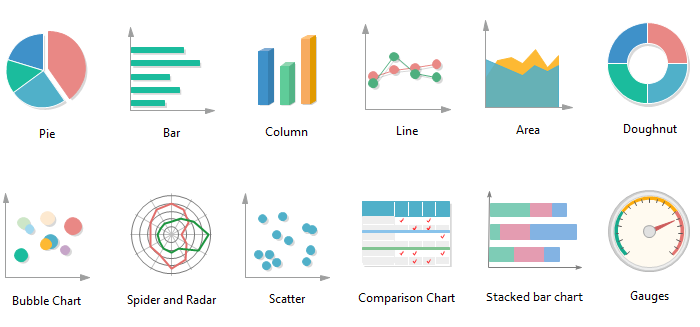
Source: https://www.edrawsoft.com/chart/choose-right-chart.html

### External Libraries
The objects mentioned above are typically provided by specialised data visualisation libraries, which are third-party collections of pre-written code that can be imported and utilised. Although only Python will be used in this demonstration, the R programming language is a similarly powerful tool for visualising data. A few of the most commonly used libraries for both are given in Table (1) below. 

Developed by Guido van Rossum, Python is a high-level, general-purpose language released in 1991. Its versatile design, readable syntax and open-source code make it a highly desirable option for data analyisis and visualisation.

| &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Python &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; R &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|
| :-: | :-: |
| Matplotlib | ggplot2 |
| Seaborn | Lattice |
| ggplot | Plotly |

Table (1): Most common data visualisation libraries for Python and R.

## Example: Distance from the Earth to the Sun

In this section of the notebook, we will use a very simple dataset to demonstrate data visualisation in the context of physics. The aim is to visually represent the numerical data and highlight the key aspects of data analysis.

The dataset used in this notebook is the open-source [Earth-Sun Distance in Astronomical Units for Days of the Year](https://www.usgs.gov/media/files/earth-sun-distance-astronomical-units-days-year) dataset.

### Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Load and Clean Data

In [5]:
df = pd.read_csv('earth_sun_distance.csv')

df.dropna(axis="columns", how="all", inplace=True)
df.dropna(axis="rows", how="all", inplace=True)
df['DOY'] = df['DOY'].astype('int')

print(df)

     DOY        d
0      1  0.98331
1      2  0.98330
2      3  0.98330
3      4  0.98330
4      5  0.98330
..   ...      ...
361  362  0.98340
362  363  0.98337
363  364  0.98335
364  365  0.98333
365  366  0.98331

[366 rows x 2 columns]


### Display Data

Since our continuous dependent variable was measured over the range of days in a calendar year, the data is best represented by a simple line plot, which will be called with the syntax `plt.plot(x, y)` in the code below.

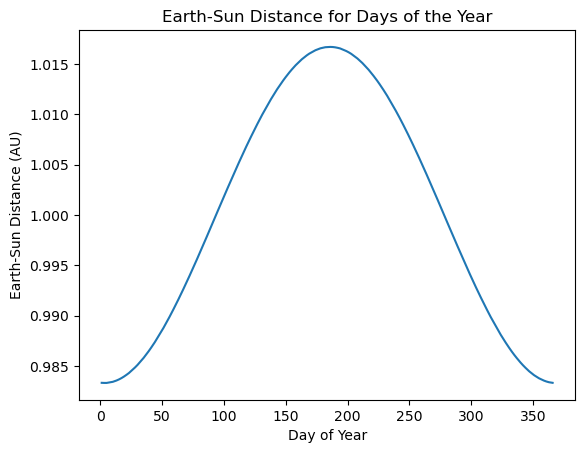

In [9]:
plt.plot(df['DOY'], df['d'])
plt.title("Earth-Sun Distance for Days of the Year")
plt.xlabel("Day of Year")
plt.ylabel("Earth-Sun Distance (AU)")
plt.show()